**Retail Promotion Classification-Prediction Problem**

Through this project, we are aiming to use retail sales data to understand how the stores could run a promotional campaign targeting specific customer profiles.

This project would allow retail stores, particularly one without a lot of resources dedicated to promotional material, to optimize their promotional campaigns by identifying the most effective customer profiles to target with their marketing efforts. This approach can save retailers significant resources and effort by avoiding a standarized approach to promotions, which can be less effective and less efficient. Instead, stores can target specific customer segments based on their preferences in shopping categories, past purchasing behaviors, and other factors to maximize the effectiveness of their promotions.

Data Source: https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset

***Step 1: Data Cleaning and Preprocessing***

Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score


In [3]:
df = pd.read_csv('customer_shopping_data.csv')
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


Creating a new calculated column total which just calculates the total amount spent by that person by doing price * quantity

In [5]:
df['Total'] = (df['price'] * df['quantity'])
df.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,Total
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon,7502.00
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul,5401.53
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity,300.08
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM,15004.25
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon,242.40


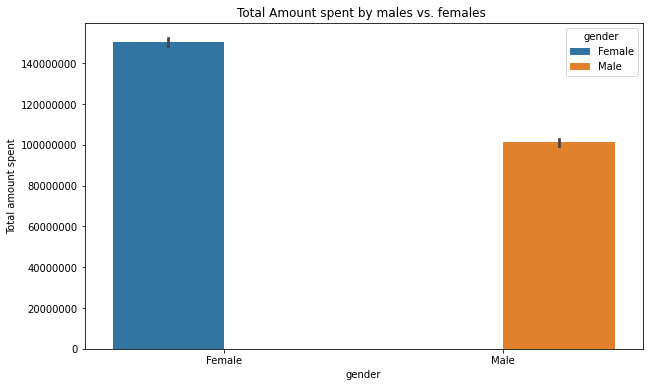

In [6]:
plt.figure(figsize=(10,6))
sns.barplot(df,x='gender',y='Total',hue = 'gender',estimator = sum)
plt.ylabel('Total amount spent')
plt.title('Total Amount spent by males vs. females ')
plt.ticklabel_format(style='plain',axis='y')
plt.show()

Text(0.5, 1.0, 'Category Wise Shopping')

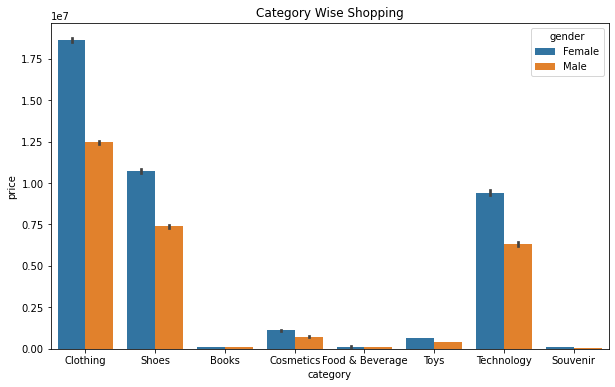

In [7]:
plt.figure(figsize=(10,6))
sns.barplot(df,x='category',y='price',hue = 'gender',estimator = sum)
plt.title('Category Wise Shopping')

Starting the Machine Learning Process 

In [8]:
# Choose relevant columns for predictions
df_to_train = df[['gender', 'category', 'age', 'Total']]

In [9]:
df_to_train.head()

,gender,category,age,Total
0,Female,Clothing,28,7502.00
1,Male,Shoes,21,5401.53
2,Male,Clothing,20,300.08
3,Female,Shoes,66,15004.25
4,Female,Books,53,242.40


Creating age groups

In [10]:
def age_to_categories(x):
    if (x<=20):
        return '0-20'
    elif ((x>20) & (x<=30)):
        return '20 to 30'
    elif ((x>30) & (x<=40)):
        return '30 to 40'
    elif ((x>40) & (x<50)):
        return '40 to 50'
    elif ((x>50) & (x<60)):
        return '50 to 60'
    else:
        return '> 60'
df_to_train['age_group'] = df['age'].apply(age_to_categories)

/var/folders/bf/7xcdz0ts5pj314jx9d2_0y640000gn/T/ipykernel_17548/3725435486.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_train['age_group'] = df['age'].apply(age_to_categories)


In [11]:
df_to_train.head()

,gender,category,age,Total,age_group
0,Female,Clothing,28,7502.00,20 to 30
1,Male,Shoes,21,5401.53,20 to 30
2,Male,Clothing,20,300.08,0-20
3,Female,Shoes,66,15004.25,> 60
4,Female,Books,53,242.40,50 to 60


In [12]:
df_to_train.describe().T

,count,mean,std,min,25%,50%,75%,max
age,99457.0,43.427089,14.990054,18.00,30.00,43.00,56.00,69.0
Total,99457.0,2528.789268,4222.475781,5.23,136.35,600.17,2700.72,26250.0


For a certain category, assign labels based on max and min values? 

Creating one-hot-encoding of the categories and age groups

In [13]:
df_dummy = pd.get_dummies(df_to_train)
df_dummy.head()

,age,Total,gender_Female,gender_Male,category_Books,category_Clothing,category_Cosmetics,category_Food & Beverage,category_Shoes,category_Souvenir,category_Technology,category_Toys,age_group_0-20,age_group_20 to 30,age_group_30 to 40,age_group_40 to 50,age_group_50 to 60,age_group_> 60
0,28,7502.00,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,21,5401.53,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,20,300.08,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
3,66,15004.25,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,53,242.40,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [14]:
X = df_dummy.drop('Total', axis =1)
y = df_dummy.Total.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [15]:
df_dummy.dtypes

age                           int64
Total                       float64
gender_Female                 uint8
gender_Male                   uint8
category_Books                uint8
category_Clothing             uint8
category_Cosmetics            uint8
category_Food & Beverage      uint8
category_Shoes                uint8
category_Souvenir             uint8
category_Technology           uint8
category_Toys                 uint8
age_group_0-20                uint8
age_group_20 to 30            uint8
age_group_30 to 40            uint8
age_group_40 to 50            uint8
age_group_50 to 60            uint8
age_group_> 60                uint8
dtype: object

Linear Regression to see fit with a Linear Model 

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

lr_mae = mean_absolute_error(y_test, lr_pred)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

In [17]:
print('Linear Regression - MAE:', lr_mae, 'MSE:', lr_mse, 'R-squared:', lr_r2)


Linear Regression - MAE: 1743.3081649239225 MSE: 9268645.423660858 R-squared: 0.48426378260206915


As the R-squared value is approximately 0.483, we can tell that this is not a good model. 

Classification using age groups - incomplete


In [18]:
df_to_train["gender"].replace('Female', 1,inplace=True)
df_to_train["gender"].replace('Male', 0,inplace=True)
df_to_train["category"].replace('Clothing', 0,inplace=True)
df_to_train["category"].replace('Cosmetics', 1,inplace=True)
df_to_train["category"].replace('Food & Beverage', 2,inplace=True)
df_to_train["category"].replace('Shoes', 3,inplace=True)
df_to_train["category"].replace('Souvenir', 4,inplace=True)
df_to_train["category"].replace('Technology', 5,inplace=True)
df_to_train["category"].replace('Toys', 6,inplace=True)
df_to_train["category"].replace('Books', 7,inplace=True)


X = df_to_train.drop('age_group', axis =1)
y = df_to_train.age_group.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
df_to_train


/var/folders/bf/7xcdz0ts5pj314jx9d2_0y640000gn/T/ipykernel_17548/1365880988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_train["gender"].replace('Female', 1,inplace=True)
/var/folders/bf/7xcdz0ts5pj314jx9d2_0y640000gn/T/ipykernel_17548/1365880988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_train["gender"].replace('Male', 0,inplace=True)
/var/folders/bf/7xcdz0ts5pj314jx9d2_0y640000gn/T/ipykernel_17548/1365880988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

,gender,category,age,Total,age_group
0,1,0,28,7502.00,20 to 30
1,0,3,21,5401.53,20 to 30
2,0,0,20,300.08,0-20
3,1,3,66,15004.25,> 60
4,1,7,53,242.40,50 to 60
...,...,...,...,...,...
99452,1,4,45,293.25,40 to 50
99453,0,2,27,20.92,20 to 30
99454,0,2,63,20.92,> 60
99455,0,5,56,16800.00,50 to 60


Following code did not fully execute after two minutes - not sure if this is the way to go. 

In [19]:
'''
from sklearn.svm import SVC
classifier1 = SVC(kernel = 'linear', random_state = 40)
classifier1.fit(X_train, y_train)
Y_pred = classifier1.predict(X_test)
acc1 = accuracy_score(y_test, Y_pred)
acc1
'''

"\nfrom sklearn.svm import SVC\nclassifier1 = SVC(kernel = 'linear', random_state = 40)\nclassifier1.fit(X_train, y_train)\nY_pred = classifier1.predict(X_test)\nacc1 = accuracy_score(y_test, Y_pred)\nacc1\n"